In [1]:
# torch
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from tqdm.notebook import tnrange, tqdm_notebook
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# standard libraries
from PIL import Image
import matplotlib.pyplot as plt
import math
import random
import os
import json
import cv2
import pandas as pd
import numpy as np
import sys
import json

sys.path.append("../")

from dataset import TreeDataset
from transforms import MaskResize
from visualize import BatchVisualizer as BV
import utils

In [2]:
data_configs = {
    'root': '../data/Some Trees Dataset.v12i.coco-segmentation',
    'seed': 42,
    'transforms': {
        'image_transforms': T.Compose([
            T.ToTensor(),
            T.Resize((30, 30))
        ]),
        'mask_transforms': MaskResize(size=(30, 30)),
    },
    'batch_size': 4
}

In [3]:
utils.set_seed(data_configs['seed'])
train_set = TreeDataset(data_configs['root'], 
                        'train', 
                        data_configs['transforms']['image_transforms'], 
                        data_configs['transforms']['mask_transforms']
)

val_set = TreeDataset(data_configs['root'], 
                        'valid', 
                        data_configs['transforms']['image_transforms'], 
                        data_configs['transforms']['mask_transforms']
)

test_set = TreeDataset(data_configs['root'], 
                        'test', 
                        data_configs['transforms']['image_transforms'], 
                        data_configs['transforms']['mask_transforms']
)

In [4]:
class CustDataset(Dataset):
    def __init__(self, ds):
        self.ds = ds

    def __getitem__(self, idx):
        return self.ds[idx]

    def __len__(self):
        return len(self.ds)

In [5]:
ts = CustDataset(train_set[:12])
vs = CustDataset(test_set[:12])

utils.set_seed(data_configs['seed'])

def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)
    
tl = DataLoader(ts, batch_size=data_configs['batch_size'], shuffle=True, collate_fn=collate_fn)
vl = DataLoader(vs, batch_size=data_configs['batch_size'], shuffle=False, collate_fn=collate_fn)

In [6]:
x, y = next(iter(tl))

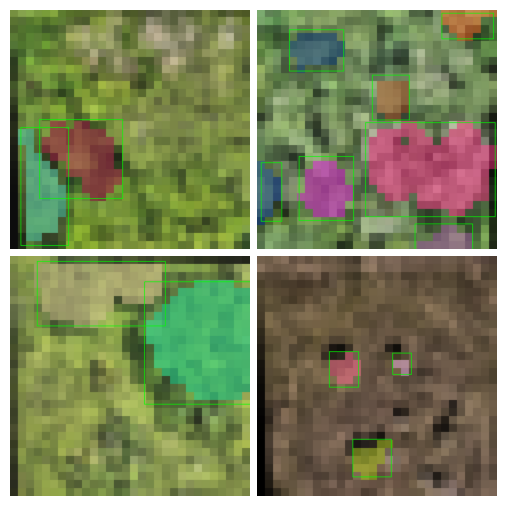

In [7]:
bv = BV(m=2, n=2, figsize=(5, 5))
f = bv.visualize_batch((x,y))
Image.fromarray(bv.fig_to_image(f[0])).save('last_batch_epoch_x.png')

In [8]:
from models.resnets import TreeMaskRCNN

backbone = TreeMaskRCNN(backbone_variant='resnet50', pretrained=False)

C:\Users\Brian\anaconda3\envs\dl_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Brian\anaconda3\envs\dl_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


```python
class InstanceSegLightningModule(pl.LightningModule):
    def __init__(self, backbone, learning_rate: float = 1e-4):
        """
        Inputs:
            backbone (nn.Module):
                - Your prebuilt model (e.g., Mask R-CNN, custom instance segmentation architecture).
                - Must accept a batch of images + targets (during training) and return loss dict.
                - Must accept a batch of images only (during inference) and return predictions.
            
            learning_rate (float):
                - Learning rate for the optimizer.

        Logic / What should happen here:
            - Save all hyperparameters.
            - Store the backbone model.
            - Initialize any metrics (if needed).
            - Setup any tracking variables for validation epoch end.
        """
        super().__init__()
        self.model = backbone
        self.learning_rate = learning_rate
        self.val_map = MeanAveragePrecision(iou_type="segm")
        self.save_hyperparameters()


    def forward(self, images):
        """
        Inputs:
            images (List[Tensor]):
                - List of input image tensors, each shaped (C, H, W).
                - Used for inference/validation where no targets are provided.

        Expected Output:
            predictions (List[Dict]):
                Each dict should contain:
                    - 'boxes': Tensor[N, 4]
                    - 'labels': Tensor[N]
                    - 'scores': Tensor[N]
                    - 'masks': Tensor[N, 1, H, W] (if mask-based instance segmentation)

        Logic:
            - Call the backbone in inference mode: model(images)
            - Return the raw predictions.
        """
        
        self.model.eval()
        with torch.no_grad():
            y_pred = self.model(images)
        return y_pred


    def training_step(self, batch, batch_idx):
        """
        Inputs:
            batch:
                Dictionary with:
                    - 'image': List[Tensor] OR Tensor B×C×H×W depending on your dataloader.
                    - 'target': List[Dict], where each dict contains:
                        'boxes', 'labels', 'masks', etc.
            batch_idx (int): Index of the batch.

        Expected Output:
            loss (Tensor):
                - A scalar tensor returned by Lightning for backward pass.

        Logic:
            - Extract images and targets from batch.
            - Call model(images, targets) → returns a dictionary of losses.
            - Sum or combine loss dict.
            - Log each loss component using self.log().
            - Return the total loss.
        """
        images, targets = batch
        losses = self.model(images, targets)
        return losses

    def validation_step(self, batch, batch_idx):
        """
        Inputs:
            batch:
                Same format as training batch.
            batch_idx (int):
                Index of batch.

        Expected Output:
            Anything you want to aggregate:
                - Usually returns individual predictions and/or loss values
                  that on_validation_epoch_end will combine.
                - Or return a dict like:
                    {'val_loss': tensor, 'preds': ..., 'targets': ...}

        Logic:
            - Extract images + targets.
            - Call the model in eval mode.
                If your model supports:
                    model(images, targets) → loss_dict  (like Mask R-CNN)
                You compute validation loss.
            - Store or return results for epoch-end metrics.
        """
        images, targets = batch
        loss_dict = self.model(images, targets)
        val_losses = sum(loss_dict.values())
        self.log("val_loss", val_losses, on_step=False, on_epoch=True)

        preds = self.forward(images)
        try:
            self.val_map.update(preds, targets)
        except:
            return preds, targets, {"val_loss": val_losses}
    
        return preds, targets, {"val_loss": val_losses}

    def on_validation_epoch_end(self):
        """
        Inputs:
            None, but uses outputs from all validation_step calls.

        Expected Outputs:
            - Log aggregated validation metrics.
            - Optionally compute AP, IoU, mask metrics, etc.

        Logic:
            - Gather all logged validation_step outputs.
            - Compute mean validation loss, metrics, etc.
            - Use self.log() to store final metrics.
        """
        pass


    def configure_optimizers(self):
        """
        Inputs:
            None, uses stored hyperparameters like learning rate.

        Expected Output:
            - A dict or optimizer instance, e.g.:
                optimizer
                or
                {"optimizer": optimizer, "lr_scheduler": scheduler}

        Logic:
            - Create optimizer (Adam/SGD) using self.model parameters.
            - Optionally create learning rate scheduler.
            - Return optimizer (and scheduler).
        """
        pass

```

In [9]:
class PredictionProcessor:
    """
    Only accepts one instance
    """
    def __init__(self, mask_threshold=0.5, score_threshold=0.5):
        self.mask_threshold = mask_threshold
        self.score_threshold = score_threshold

    def __call__(self, prediction):
        # Handle empty predictions
        if not prediction or "masks" not in prediction or "scores" not in prediction:
            return {
                "boxes": torch.empty((0, 4), dtype=torch.float32),
                "labels": torch.empty((0,), dtype=torch.int64),
                "scores": torch.empty((0,), dtype=torch.float32),
                "masks": torch.empty((0, 1, 1), dtype=torch.uint8)  # single 2D mask per instance
            }

        # Filter by score threshold
        keep = prediction["scores"] >= self.score_threshold
        prediction = {k: v[keep] for k, v in prediction.items()}

        # Threshold masks and convert to uint8
        if "masks" in prediction and len(prediction["masks"]) > 0:
            # originally: (N,1,H,W) -> convert to (N,H,W)
            prediction["masks"] = ((prediction["masks"] > self.mask_threshold)
                                    .to(torch.uint8)
                                    .squeeze(1))  # remove channel dim

        return prediction

In [10]:
class InstanceSegLightningModule(pl.LightningModule):
    def __init__(self, model, batch_visualizer, mask_threshold=0.5, score_threshold=0.5):
        super().__init__()
        self.model = model
        self.map_metric = MeanAveragePrecision(iou_type="segm")
        self.pred_processor = PredictionProcessor(mask_threshold, score_threshold)
        self.last_val_batch = None
        self.batch_visualizer = batch_visualizer
        self.logged_gt = False

    def forward(self, images):
        # self.model.eval()
        # with torch.no_grad():
        raw_pred = self.model(images)  # dict if batch_size=1, else list of dicts
        if isinstance(raw_pred, dict):
            raw_pred = [raw_pred]  # wrap single image in list
        processed_preds = [self.pred_processor(p) for p in raw_pred]
        return processed_preds

    def training_step(self, batch, batch_idx):
        images, targets = batch
        loss_dict = self.model(images, targets)
        loss = sum(loss_dict.values())
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
    
        if isinstance(targets, dict):
            targets = [targets]
    
        loss_dict = self.model(images, targets)
        if isinstance(loss_dict, dict):
            val_loss = sum(loss_dict.values())
        else:
            val_loss = torch.tensor(0.0, device=images[0].device)
    
        self.log("val/loss", val_loss, on_step=False, on_epoch=True, prog_bar=True)
    
        preds = self.forward(images)
        self.map_metric.update(preds, targets)
    
        # store the last batch for visualization
        self.last_val_batch = (images, targets, preds)
    
        return {"val_loss": val_loss}

    def on_validation_epoch_end(self):
        metrics = self.map_metric.compute()
        self.log("val/mAP", metrics["map"], prog_bar=True)
        self.map_metric.reset()

        if self.last_val_batch is None:
            return

        x, y, processed_preds = self.last_val_batch
        bv = self.batch_visualizer
        epoch_num = self.current_epoch  

        if self.logger is not None:
            save_dir = os.path.join(self.logger.log_dir, "images")
        else:
            save_dir = "./"  # fallback

        os.makedirs(save_dir, exist_ok=True)

        if not self.logged_gt:
            f_gt = bv.visualize_batch((x, y))
            gt_path = os.path.join(save_dir, "ground_truth_once.png")
            Image.fromarray(bv.fig_to_image(f_gt[0])).save(gt_path)

            self.logged_gt = True  # <-- prevents duplicate saves

        f_pred = bv.visualize_batch((x, processed_preds))
        pred_path = os.path.join(save_dir, f"pred_epoch_{epoch_num}.png")
        Image.fromarray(bv.fig_to_image(f_pred[0])).save(pred_path)

        self.last_val_batch = None

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
    
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=3
        )
    
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val/loss",
        }

In [11]:
model = InstanceSegLightningModule(backbone, BV(m=2, n=2, figsize=(5, 5)), 0.3, 0.3)

In [12]:
logger = CSVLogger(
    save_dir="logs",            # base directory
    name="instance_segmentation",  # subdirectory for this run
    version=None                # None lets Lightning auto-number versions
)


checkpoint_callback = ModelCheckpoint(
    monitor="val/mAP",          # metric to monitor
    mode="max",                 # maximize mAP
    save_top_k=3,               # save top 3 best models
    filename="epoch{epoch:02d}-map{val/mAP:.4f}"
)


lr_monitor = LearningRateMonitor(logging_interval="step")


trainer = pl.Trainer(
    max_epochs=5,
    accelerator="auto",         # GPU if available
    devices=1,
    precision=16,               # mixed precision (optional)
    logger=logger,
    callbacks=[checkpoint_callback, lr_monitor],
    log_every_n_steps=10,
    check_val_every_n_epoch=1,
    gradient_clip_val=1.0
)

C:\Users\Brian\anaconda3\envs\dl_env\lib\site-packages\lightning_fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                 | Params | Mode 
------------------------------------------------------------
0 | model      | TreeMaskRCNN         | 44.0 M | train
1 | map_metric | MeanAveragePrecision | 0      | train
------------------------------------------------------------
44.0 M    Trainable params
0         Non-trainable params
44.0 M    Total params
175.902   Total estimated model params size (MB)
208       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\Brian\anaconda3\envs\dl_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.
C:\Users\Brian\anaconda3\envs\dl_env\lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
C:\Users\Brian\anaconda3\envs\dl_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.
C:\Users\Brian\anaconda3\envs\dl_env\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.


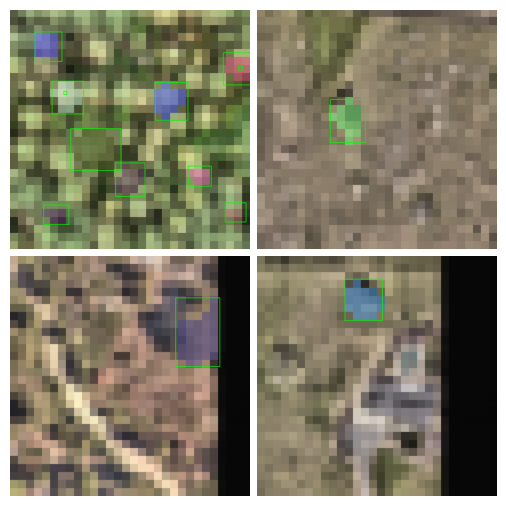

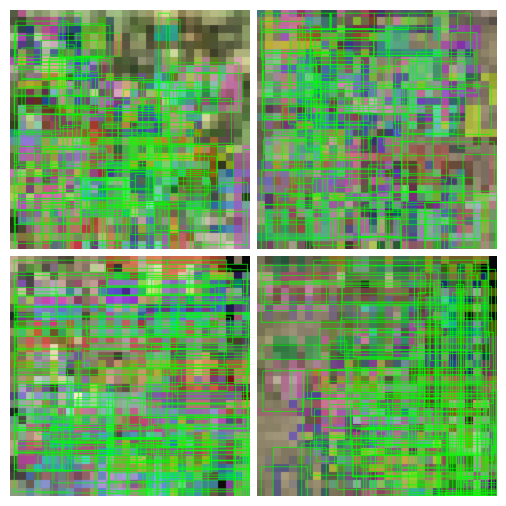

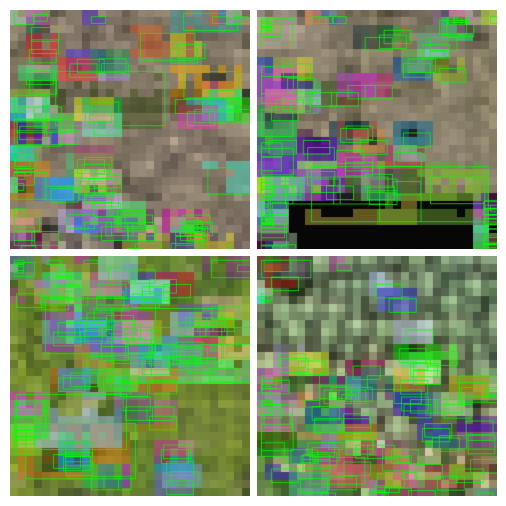

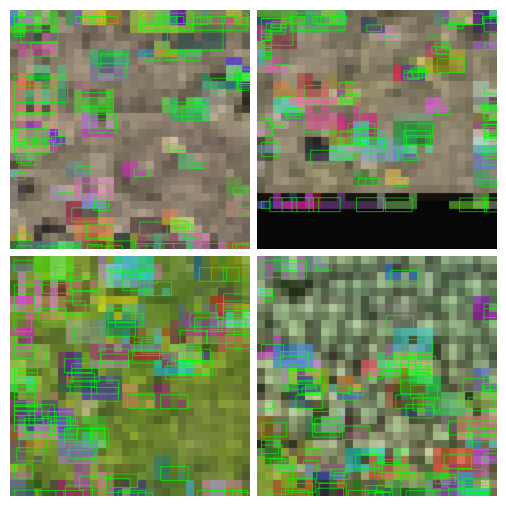

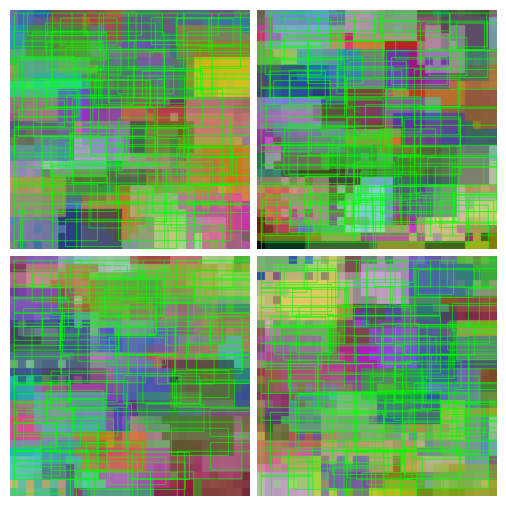

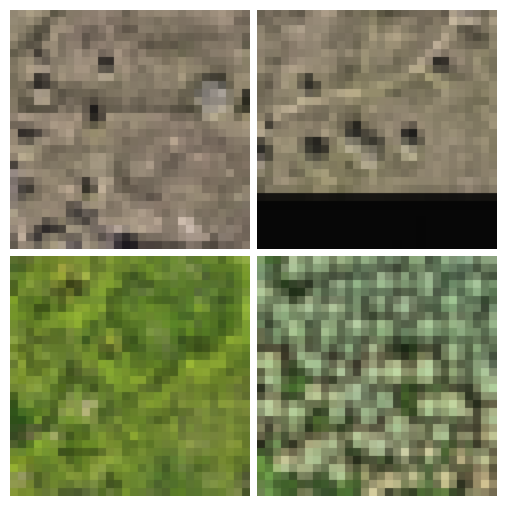

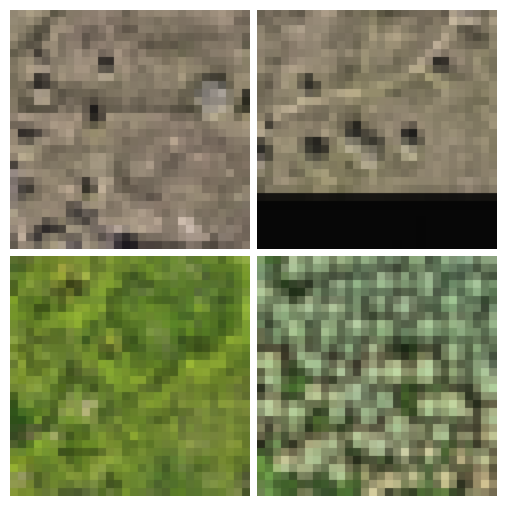

In [13]:
trainer.fit(model, tl, vl)